# Survival *lifelines*

In [41]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,matplotlib,lifelines,survival -a Filippo_Valle -g -r -b -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Filippo_Valle 
last updated: Thu Jun 18 2020 

CPython 3.7.6
IPython 7.15.0

pandas 1.0.4
numpy 1.18.5
matplotlib 3.2.1
lifelines 0.24.10
survival unknown

compiler   : GCC 7.5.0
system     : Linux
release    : 4.19.76-linuxkit
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 3c8ae8f7082ca41e4f98ab084dc707834cbe547b
Git repo   : git@github.com:fvalle1/phd.git
Git branch : master
watermark 2.0.2


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

#this notebook is intended to be run on a docker container which image inehrit jupyter/datascience-notebook
os.chdir("/home/jovyan/work/datasets/cancers/lung")

In [2]:
df_files = pd.read_csv("files.txt", sep="\t").set_index("file_name").dropna(how="all", thresh=5, axis=1)

#df_files = pd.read_csv("files.dat", sep=",",index_col=0).dropna(how="all", thresh=100, axis=1)
#df_files = df_files[df_files["dataset"]=="tcga"]
df_files.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1145 entries, 1142583c-2ca0-4f95-a94b-6f1a35ab1580.FPKM.txt.gz to e30a275e-eaf3-43d4-b29c-dc75d77a0c9e.FPKM.txt.gz
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   cases.0.demographic.days_to_birth              1098 non-null   float64
 1   cases.0.demographic.days_to_death              456 non-null    float64
 2   cases.0.demographic.gender                     1145 non-null   object 
 3   cases.0.demographic.vital_status               1145 non-null   object 
 4   cases.0.diagnoses.0.age_at_diagnosis           1098 non-null   float64
 5   cases.0.diagnoses.0.days_to_last_follow_up     869 non-null    float64
 6   cases.0.diagnoses.0.last_known_disease_status  1145 non-null   object 
 7   cases.0.diagnoses.0.tumor_stage                1145 non-null   object 
 8   cases.0.exposures.0.cigarettes_per_day    

In [3]:
df_files["cases.0.diagnoses.0.last_known_disease_status"].unique()

array(['not reported'], dtype=object)

## preprocessing data
We bin *age_at_diagnosis*

In [4]:
bins = np.linspace(0,100,20)
avg = df_files["cases.0.diagnoses.0.age_at_diagnosis"].mean(skipna=True)
df_files["age_at_diagnosis"]=pd.cut(df_files["cases.0.diagnoses.0.age_at_diagnosis"].fillna(avg)/365., bins=bins, labels = (bins[1:]+bins[:-1])/2).__array__()

we set *gender* as an **int**

In [5]:
df_files["gender"] = (df_files["cases.0.demographic.gender"]=="male").astype(int)

We clean stages code. At the end we want *i*, *ii*, *iii*, *iv* without other signs

In [6]:
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
df_files["cases.0.diagnoses.0.tumor_stage"].unique()

array(['stage iii', 'stage i', 'stage ii', 'stage iv', 'not reported'],
      dtype=object)

we substitute stage with *int*

In [7]:
df_files["tumor_stage"]=df_files["cases.0.diagnoses.0.tumor_stage"]
for i,stage in enumerate(["stage i", "stage ii", "stage iii", "stage iv", "stage v"]):
    df_files["tumor_stage"].replace(stage, i+1, inplace=True)

We get the *Alive* status as an **int**

In [8]:
#1 = Alive
df_files["vital_status"]=(df_files["cases.0.demographic.vital_status"]=="Dead").astype(int)

We define a function to estimate the number of days the patient survived.

We consider *days_to_last_follow_up* if the patient is *alive*, *days_to_death* if the patient is *dead*

In [9]:
def get_survival(case):
    if case["cases.0.demographic.vital_status"] == 1:
        return case["cases.0.demographic.days_to_death"]
    else:
        return case["cases.0.diagnoses.0.days_to_last_follow_up"]

df_files["days_survival"] = df_files.apply(get_survival,1)

In [10]:
subset = df_files[~df_files["days_survival"].isna()]
data = {}
data["duration"]=subset["days_survival"]/365
data["observed"]=subset["vital_status"]
data["entry"]=subset["cases.0.demographic.days_to_birth"]/365

Import out survival helper functions.

Needs *lifelines* [https://lifelines.readthedocs.io/](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)

In [37]:
from survival import fit_cox, add_group_to_subset, save_plot

Comment the lines corresponding to the analyses you want to perform

In [17]:
# uncomment for analyses on TCGA

df_clusters = pd.read_csv("topsbm/topsbm_level_1_topic-dist.csv",index_col=1).drop("i_doc",1)
#df_clusters = pd.read_csv("lda/lda_level_2_topic-dist.csv",index_col=1).drop("i_doc",1)

# uncomment for analyses on unified dataset

#df_clusters = pd.read_csv("topsbm/topsbm_level_1_topic-dist.csv",index_col=1).drop("i_doc",1)
#df_clusters = df_clusters[df_clusters.index.isin(filter(lambda doc: "GTEX" not in doc,df_clusters.index))]

*df_files* stores all the patient's metadata

In [18]:
df_files.head(2)

,cases.0.demographic.days_to_birth,cases.0.demographic.days_to_death,cases.0.demographic.gender,cases.0.demographic.vital_status,cases.0.diagnoses.0.age_at_diagnosis,cases.0.diagnoses.0.days_to_last_follow_up,cases.0.diagnoses.0.last_known_disease_status,cases.0.diagnoses.0.tumor_stage,cases.0.exposures.0.cigarettes_per_day,cases.0.exposures.0.years_smoked,cases.0.project.project_id,cases.0.submitter_id,id,age_at_diagnosis,gender,tumor_stage,vital_status,days_survival
file_name,,,,,,,,,,,,,,,,,,
1142583c-2ca0-4f95-a94b-6f1a35ab1580.FPKM.txt.gz,-19088.0,444.0,male,Dead,19088.0,26.0,not reported,stage iii,1.972603,NaN,TCGA-LUAD,TCGA-86-8359,b6b856ca-d5b2-4589-95ec-6495d61fc2fd,50.0,1,3,1,26.0
ab51cccb-b5df-434a-a5a4-32368ccf0b24.FPKM.txt.gz,-18856.0,761.0,male,Dead,18856.0,246.0,not reported,stage i,3.287671,30.0,TCGA-LUAD,TCGA-44-2668,e557764a-1399-4143-a2f5-d90359d746bc,50.0,1,1,1,246.0


We fit a cox model on each dataset *LUAD* and *LUSC*. We set topic to $1$ if sample's expression is above the $50^{th}$ percentile.

113
Too low -log2(p): -0.0
21
TCGA-LUAD :  Topic 2 
 coef   -1.173574
p       0.103677
Name: Topic_2, dtype: float64 

125
Too low -log2(p): -0.0
111
Too low -log2(p): -0.0
71
Too low -log2(p): -0.0
85
Too low -log2(p): -0.0
111
Too low -log2(p): -0.0
108
Too low -log2(p): -0.0
46
Too low -log2(p): -0.0
21
Too low -log2(p): -0.0
23
Too low -log2(p): -0.0
109
Too low -log2(p): 0.08296378704148827
34
TCGA-LUSC :  Topic 1 
 coef    0.551171
p       0.056747
Name: Topic_1, dtype: float64 

127
Too low -log2(p): -0.0
25
TCGA-LUSC :  Topic 3 
 coef    0.583845
p       0.056964
Name: Topic_3, dtype: float64 

34
TCGA-LUSC :  Topic 4 
 coef    0.623839
p       0.025089
Name: Topic_4, dtype: float64 

74
Too low -log2(p): -0.0
63
Too low -log2(p): -0.0
33
Too low -log2(p): -0.0
31
Too low -log2(p): 0.15915291746369473
107
Too low -log2(p): -0.0
125
Too low -log2(p): -0.0
128
Too low -log2(p): -0.0
45
Too low -log2(p): 0.7969165816936326


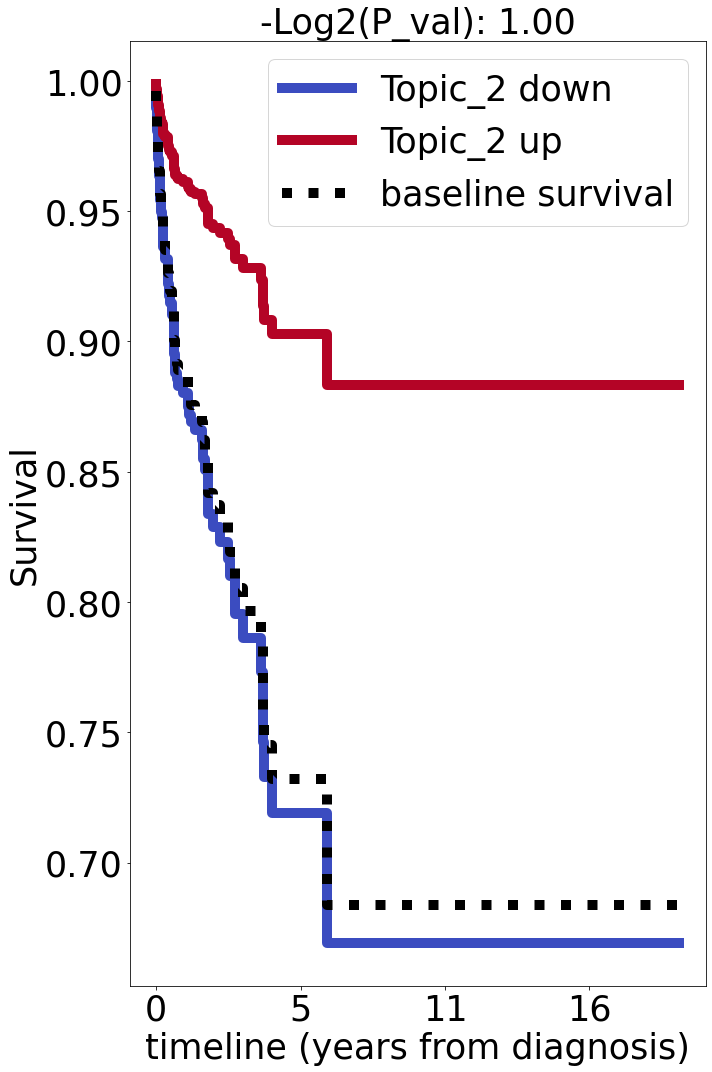

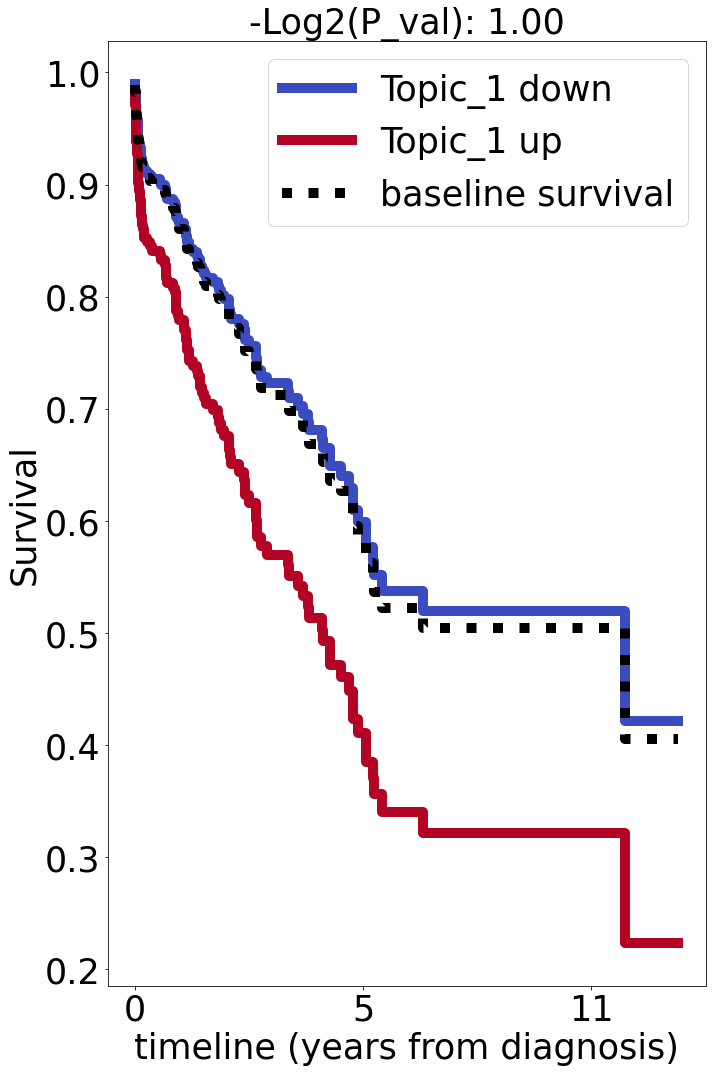

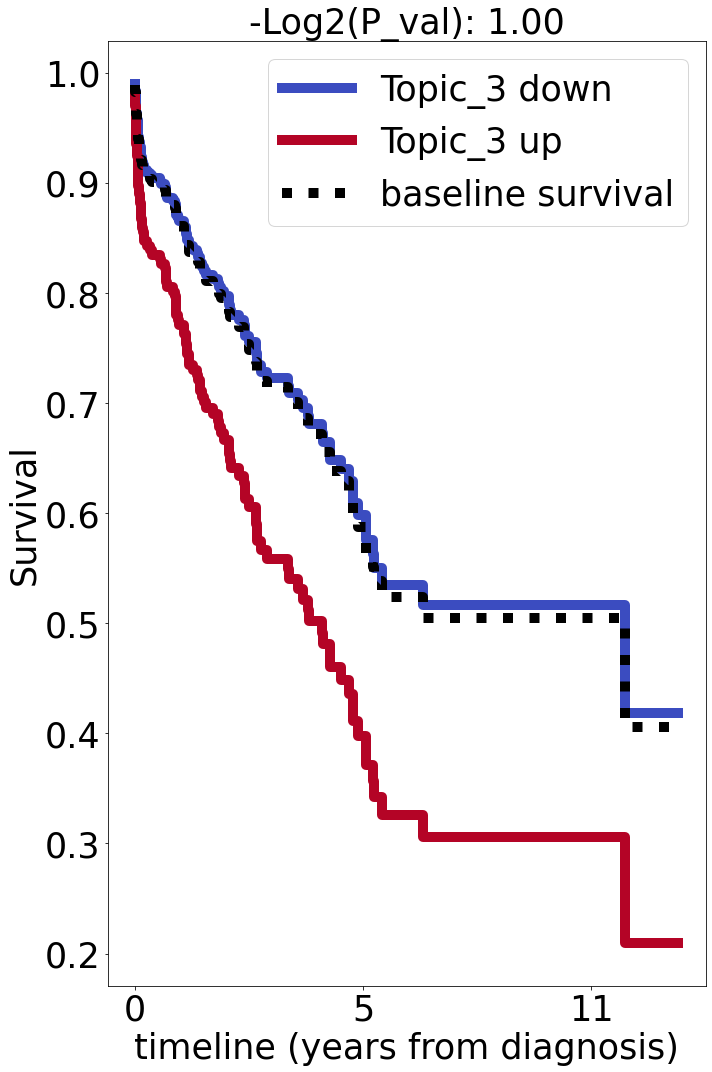

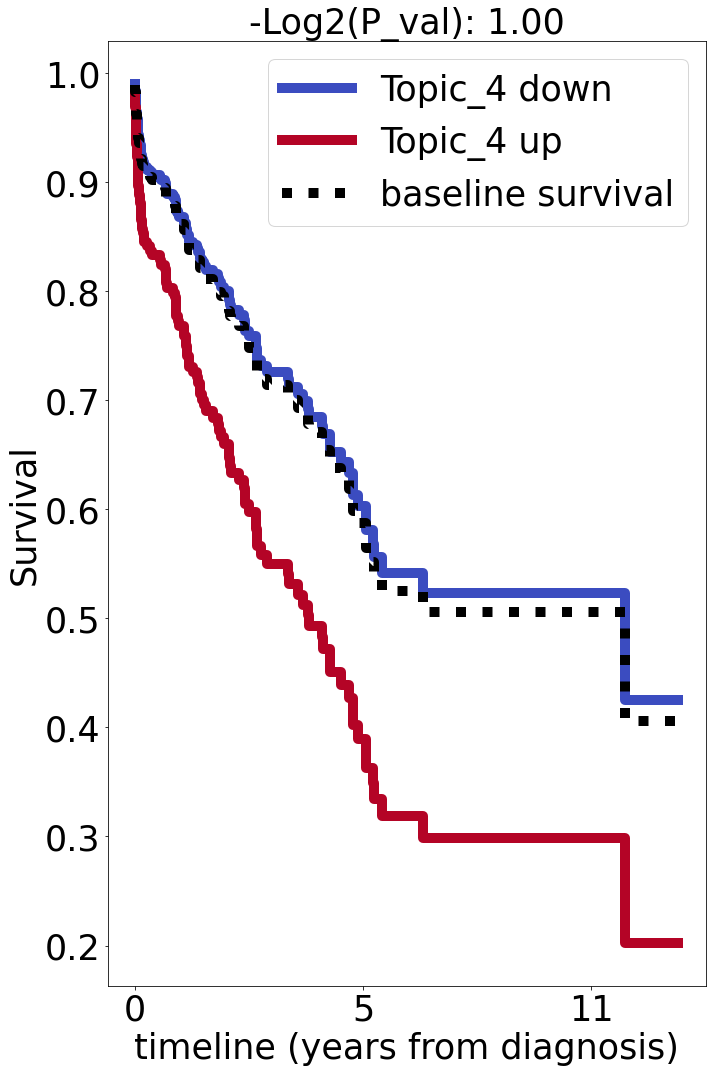

In [19]:
for dataset in ["TCGA-LUAD", "TCGA-LUSC"]:
    # we choose only patients with all property set correctly
    mask = (~df_files["days_survival"].isna()) & (df_files["cases.0.diagnoses.0.tumor_stage"]!="not reported") & (df_files["cases.0.project.project_id"]==dataset)
    subset = df_files[mask]

    # select the necessary labels to pass to cox
    subset = subset[["days_survival","vital_status","gender", "tumor_stage", "age_at_diagnosis"]]
    for topic in df_clusters.columns:
        # we add a topic column to the subset
        top_set = add_group_to_subset(topic, subset, df_clusters, 0.5)
        print(top_set["group"].sum())
        
        # we retrive the fit result
        summary, _, ax = fit_cox(top_set, topic)
        
        # check if the fit exited correctly
        if summary is not None:
            # print topics with a significant distance from baseline
            if summary.at[summary.index[-1],"-log2(p)"] > 3:
                print(dataset,": ",topic,"\n",summary.loc[summary.index[-1],["coef", "p"]],"\n")
                
        # we save the plot
        if ax is not None:
            ax.set_title(dataset+" "+ax.title.get_text(), fontsize=35)
            save_plot(ax, dataset, topic)

                      coef  exp(coef)         p  -log2(p)  corrected_p  \
gender            0.341169   1.406591  0.127998  2.965810     0.511991   
tumor_stage       0.274486   1.315855  0.022441  5.477746     0.089762   
age_at_diagnosis  0.030686   1.031162  0.009788  6.674802     0.039151   
Topic_3           0.796079   2.216832  0.018296  5.772297     0.073186   

                  -log2(corrected_p)  
gender                      0.965810  
tumor_stage                 3.477746  
age_at_diagnosis            4.674802  
Topic_3                     3.772297  


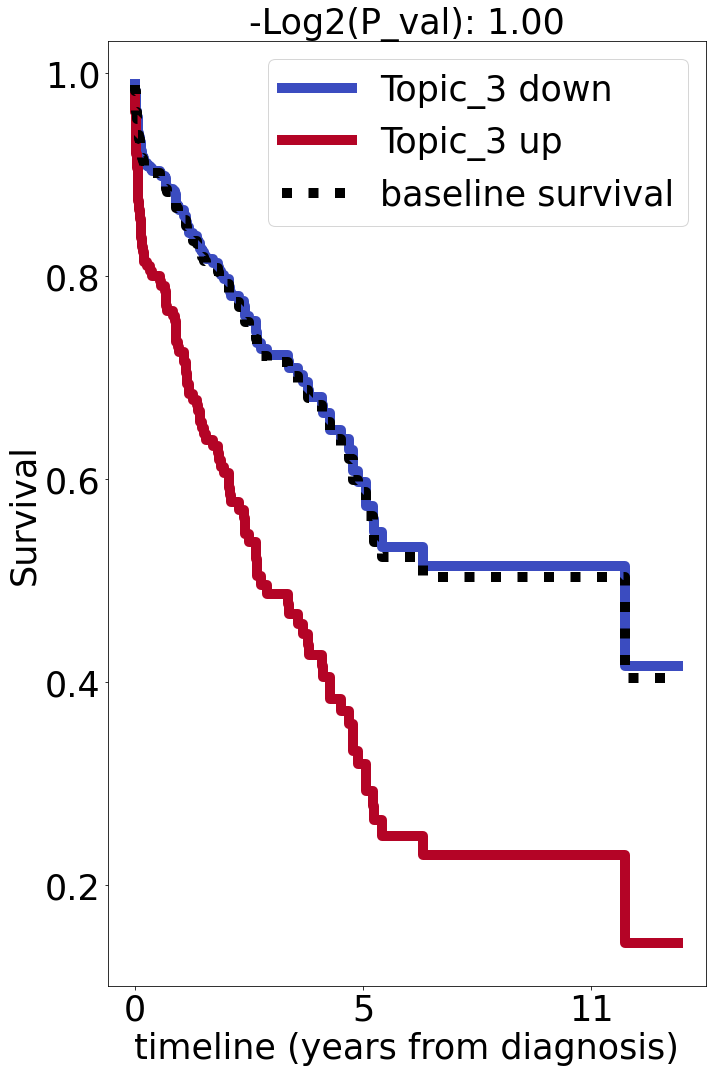

In [15]:
summary, _, ax = fit_cox(top_set, "Topic 3")
print(summary[["coef", "exp(coef)", "p", "-log2(p)", "corrected_p", "-log2(corrected_p)"]])
save_plot(ax, "all", "Topic 3")

Please use the following cell to print the **sorted** list of genes in a Topic

In [35]:
topic = "Topic 3"
df_word_distr = pd.read_csv("/home/jovyan/work/datasets/cancers/lung/topsbm/topsbm_level_2_word-dist.csv",index_col=0)
df_word_distr.sort_values(by=[topic], ascending=False, inplace=True)
df_word_distr = df_word_distr[df_word_distr[topic]>df_word_distr[topic].quantile(0.75)]
print(("gene", "P(gene|topic)"))
for g in df_word_distr[topic].items():
    print(g)

('gene', 'P(gene|topic)')
('ENSG00000168484', 0.28194832592346203)
('ENSG00000096088', 0.1691183094603812)
('ENSG00000161055', 0.124443269688627)
('ENSG00000202198', 0.0655048463627283)
('ENSG00000163993', 0.0551003376763)
('ENSG00000204305', 0.039924208450520166)
('ENSG00000171557', 0.03735723499439186)
('ENSG00000164266', 0.037053316424769264)
('ENSG00000160180', 0.03039977666439965)
('ENSG00000171560', 0.02361556181872)
('ENSG00000171564', 0.023053262966779817)
('ENSG00000130600', 0.012349785524566422)
('ENSG00000167653', 0.011760757677903732)
('ENSG00000245532', 0.009876858531350636)
('ENSG00000171747', 0.006471386611149554)
('ENSG00000200087', 0.006197166924551968)
('ENSG00000229314', 0.00466074470939148)
('ENSG00000021826', 0.004531059586848939)
('ENSG00000142748', 0.004527099735778938)
('ENSG00000183036', 0.004118245112801308)
('ENSG00000129437', 0.004070726899961292)
('ENSG00000120875', 0.0037321596334761852)
('ENSG00000108176', 0.0027184377595558637)
('ENSG00000188257', 0.0026